In [833]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Reddit characterization

## Import data: scores and predictions for action

Since our reference model is the classifier and we thus have the probability of class "Action" for each comment, we can decide whether to use:
1. % of "Action" comments within subreddit (average/median over multiple sample sets)
2. Average/median probability of action (average/media over multiple sample sets)

In [843]:
list_subreddits = pd.read_csv('../data/top_1000_subreddits.csv') # not shared, contact the authors for access
list_subreddits

,subreddit_name
0,funny
1,AskReddit
2,todayilearned
3,worldnews
4,science
...,...
995,bdsm
996,fatpeoplestories
997,Amd
998,languagelearning


In [844]:
socdim_scores = pd.read_csv('../data/scores_socdim_top10k_subreddits.csv') # From Waller and Anderson (2021)
socdim_scores = socdim_scores[socdim_scores['community'].isin(list_subreddits['subreddit_name'])]
socdim_scores.shape

(997, 15)

In [845]:
socdim_scores.columns

Index(['community', 'age', 'age B', 'age neutral', 'affluence', 'gender',
       'gender B', 'gender neutral', 'partisan B', 'partisan B neutral',
       'partisan', 'partisan neutral', 'edginess', 'sociality', 'time'],
      dtype='object')

In [846]:
filter_type = "non-filtere"

In [847]:
predictions_action_non_filtered = pd.read_csv(f'../data/predictions/predictions_roberta_simplified_synthetic_weights_downstream_{filter_type}.csv')

### Clean prediction file

In [848]:
predictions_action_non_filtered["prob_action"] = predictions_action_non_filtered["class_probabilities"].apply(lambda x: float(x.split(",")[0].replace("[", "")))
predictions_action_non_filtered["prob_no_action"] = predictions_action_non_filtered["class_probabilities"].apply(lambda x: float(x.split(",")[1].replace("]", "")))

### Generate avg. probability of action per subreddit

In [849]:
predictions_subs_non_filtered = predictions_action_non_filtered.groupby("subreddit").agg({"prob_action": "mean", "prob_no_action": "mean"}).reset_index()

### Generate the % of action comments per subreddit

In [850]:
predictions_subs_perc_non_filtered = predictions_action_non_filtered.groupby("subreddit")["predictions"].value_counts(normalize=True).unstack().reset_index()
predictions_subs_perc_non_filtered.columns = ["subreddit", "perc_action", "perc_noaction"]

### Merge

In [851]:
merged_preds_non_filtered = pd.merge(predictions_subs_non_filtered, predictions_subs_perc_non_filtered, on="subreddit")

In [852]:
merged_all = merged_preds_non_filtered.copy()

In [853]:
merged_all

,subreddit,prob_action,prob_no_action,perc_action,perc_noaction
0,1200isplenty,0.029352,0.970648,0.029191,0.970809
1,2007scape,0.021002,0.978998,0.020869,0.979131
2,2healthbars,0.005709,0.994291,0.004405,0.995595
3,2meirl4meirl,0.037004,0.962996,0.036342,0.963658
4,4chan,0.032586,0.967414,0.033729,0.966271
...,...,...,...,...,...
571,youdontsurf,0.018471,0.981529,0.019608,0.980392
572,youseeingthisshit,0.013227,0.986773,0.013761,0.986239
573,youtube,0.028405,0.971595,0.029468,0.970532
574,youtubehaiku,0.017123,0.982877,0.016832,0.983168


In [854]:
# check for nan values
merged_all[merged_all.isna().any(axis=1)]

# substitute nan values with 0
merged_all = merged_all.fillna(0)

# Plots

In [857]:
var_interest = "perc_action"

Boxplots

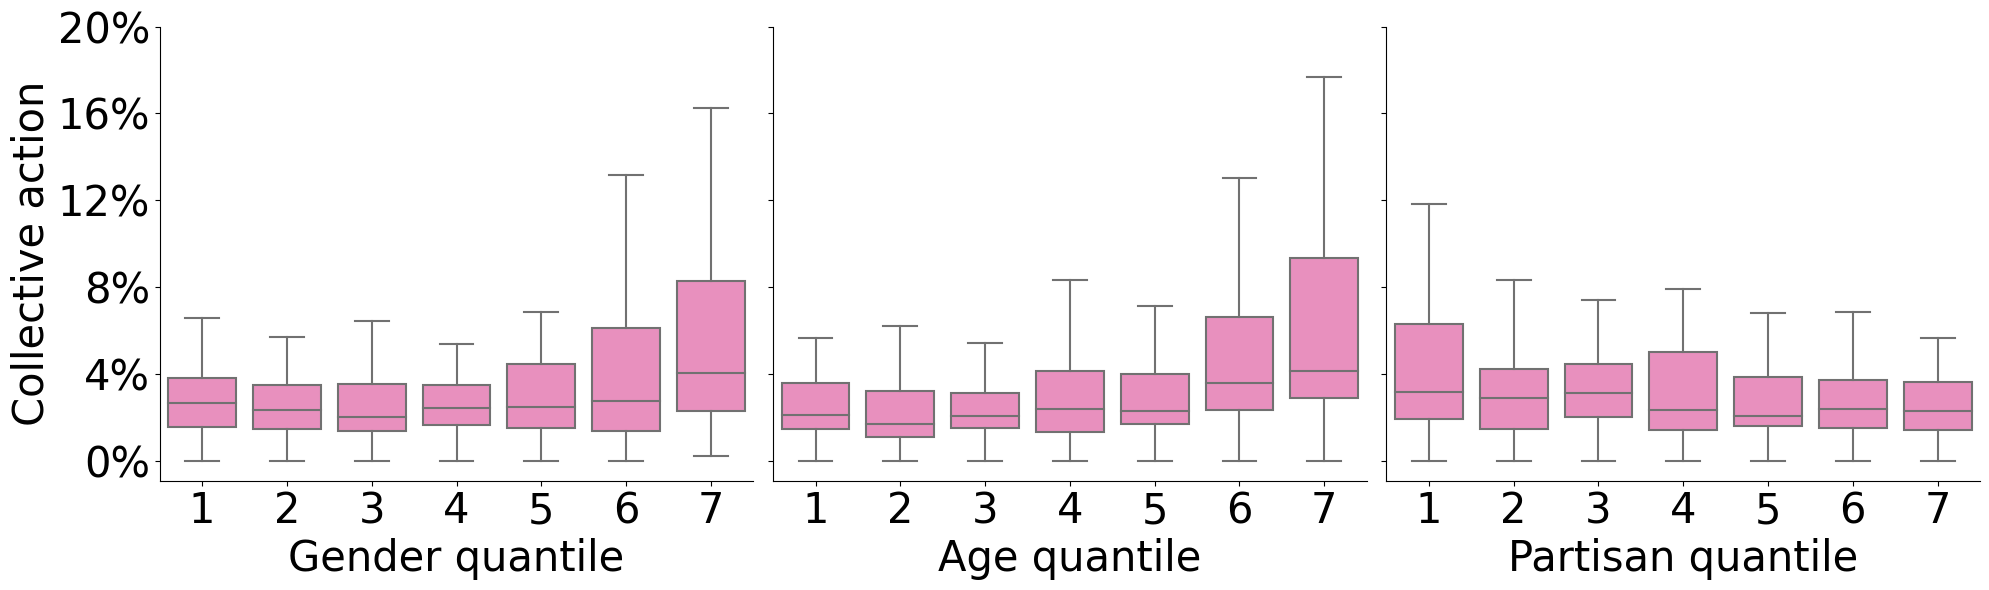

In [858]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)  # Create subplots with shared y-axis

for i, metric in enumerate(["gender", "age", "partisan"]):
    # Merge data
    merged = socdim_scores.merge(merged_all, left_on="community", right_on="subreddit", how="inner")

    # Remove NaNs
    merged = merged[~np.isnan(merged[metric])]
    merged = merged[~np.isnan(merged[var_interest])]

    # Remove duplicates
    merged = merged.drop_duplicates(subset=["community"])

    # Create bins for the metric
    merged["binned_metric"] = pd.qcut(merged[metric], q=7, labels=[f"{i+1}" for i in range(7)])

    # Create boxplot on the corresponding axis
    sns.boxplot(
        x="binned_metric",
        y=var_interest,
        data=merged,
        ax=axes[i],
        showfliers=False,
        color='#F781BF'
    )

    # Add labels and formatting
    axes[i].set_xlabel(metric.capitalize()+" quantile", fontsize=30)
    axes[i].tick_params(axis='x', labelsize=30)
    axes[i].set_ylabel("")

# Set y-axis label only on the first subplot
axes[0].set_ylabel("Collective action", fontsize=30)

# Set y-axis ticks and format as percentages
y_ticks = np.linspace(0, 0.2, 6)
axes[0].set_yticks(y_ticks)
axes[0].set_yticklabels([f"{int(y*100)}%" for y in y_ticks], fontsize=30)

# Remove top and right borders for all subplots
for ax in axes:
    sns.despine(ax=ax, top=True, right=True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Climate change focus

In [859]:
def boolean_substring_match(text, list_words):
    for word in list_words:
        if word in text:
            return True
    return False

In [860]:
climatechange_terms = ["carbon dioxide", "carbon footprint", "carbon tax", "climate change", "climate model", "emission", "fossil fuel", "global warming", "greenhouse gas", "renewable", "sea level"]

In [861]:
predictions_action = pd.read_csv(f'../data/predictions/predictions_roberta_simplified_synthetic_weights_downstream_climate_change.csv')

In [862]:
predictions_action["climatechange_boolean"] = predictions_action["text"].apply(lambda x: boolean_substring_match(x, climatechange_terms))
# transform boolean to integer
predictions_action["climatechange_boolean"] = predictions_action["climatechange_boolean"].astype(int)

In [863]:
predictions_action = predictions_action[predictions_action["climatechange_boolean"] > 0]

In [864]:
# describe subreddit value counts
predictions_action["subreddit"].value_counts().describe()

count     1609.000000
mean       447.275948
std       3192.211318
min          1.000000
25%          6.000000
50%         25.000000
75%        116.000000
max      82353.000000
Name: subreddit, dtype: float64

In [865]:
# remove subreddits with less 100 comments
predictions_action = predictions_action[predictions_action["subreddit"].map(predictions_action["subreddit"].value_counts()) > 100]

In [866]:
predictions_subs_perc = predictions_action.groupby("subreddit")["predictions"].value_counts(normalize=True).unstack().reset_index()
predictions_subs_perc.columns = ["subreddit", "perc_action", "perc_noaction"]

In [867]:
predictions_subs_perc.sort_values(by="perc_action", ascending=False)[["subreddit", "perc_action"]]

,subreddit,perc_action
50,ClimateOffensive,0.622047
167,SandersForPresident,0.570152
156,Political_Revolution,0.562406
128,MarchAgainstTrump,0.496855
34,BlueMidterm2018,0.494331
...,...,...
202,Warthunder,0.012987
221,astrophotography,0.007519
197,Unity3D,0.006711
321,italy,0.004630


In [868]:
predictions_subs_perc["climatechange_counts"] = predictions_subs_perc["subreddit"].apply(lambda x: predictions_action[predictions_action["subreddit"] == x]["climatechange_boolean"].sum())

### Perc. of comments that are climate-change related

Compute total number of comments

In [869]:
directory = "../data/subreddit_counts_summed/" # not shared, contact the authors for access

In [870]:
all_df = []
for file in os.listdir(directory):
      if file.endswith(".txt"):
            # read file
            with open(directory+file, "r") as f:
                  data = f.read()
            # to dataframe
            data = data.split("\n")
            data = [x.split("\t") for x in data]
            data = pd.DataFrame(data, columns=["subreddit", "count"])
            # remove None values
            data = data[data["subreddit"].notna()]
            # substitute nan values with 0 in count
            data["count"] = data["count"].fillna(0)
            data["count"] = data["count"].astype(int)
            all_df.append(data)

df = all_df[0]
for i in range(1, len(all_df)):
    df = pd.merge(df, all_df[i], on="subreddit", suffixes=("", "_"+str(i+1)), how="outer")

# fill nan values with 0
df = df.fillna(0)    

In [871]:
df.head()

,subreddit,count,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9,count_10,count_11,count_12
0,askreddit,5239698.0,5765531.0,5518956.0,5615448.0,5834042.0,5270802.0,6003147.0,5348034.0,5652413.0,5372956.0,4881624.0,5189096.0
1,politics,2245297.0,1969570.0,1722129.0,2242149.0,2208780.0,1742590.0,1856400.0,2031935.0,2048489.0,1979959.0,1772217.0,1833170.0
2,nfl,1382538.0,566417.0,432776.0,1251595.0,1285725.0,567554.0,1453026.0,338932.0,370722.0,695646.0,659657.0,1286322.0
3,cfb,1078299.0,393829.0,190103.0,1056619.0,882986.0,143143.0,769473.0,132583.0,152928.0,107328.0,140036.0,501530.0
4,the_donald,975836.0,846622.0,824002.0,987062.0,1207555.0,773070.0,786998.0,923156.0,917770.0,848672.0,862473.0,973504.0


In [872]:
df["subreddit"].tolist()

['askreddit',
 'politics',
 'nfl',
 'cfb',
 'the_donald',
 'funny',
 'fantasyfootball',
 'worldnews',
 'fortnitebr',
 'destinythegame',
 'gaming',
 'wow',
 'pics',
 'news',
 'leagueoflegends',
 'soccer',
 'askouija',
 'todayilearned',
 'showerthoughts',
 'nba',
 'dankmemes',
 'squaredcircle',
 'gonewild',
 'aww',
 'videos',
 'movies',
 'memeeconomy',
 'gifs',
 'hiphopheads',
 'teenagersnew',
 'teenagers',
 'bigbrother',
 'mma',
 'mildlyinteresting',
 'nintendoswitch',
 'unpopularopinion',
 'cringeanarchy',
 'chapotraphouse',
 'memes',
 'smashbros',
 'blackpeopletwitter',
 'relationships',
 'rocketleagueexchange',
 'ice_poseidon',
 'anime',
 'dota2',
 'rainbow6',
 'formula1',
 'marvelstudios',
 'pcmasterrace',
 'globaloffensive',
 'trashy',
 'europe',
 'pathofexile',
 'wtf',
 'wallstreetbets',
 'braincels',
 'nostupidquestions',
 'pewdiepiesubmissions',
 'hockey',
 'ukpolitics',
 'apple',
 'baseball',
 '2007scape',
 'fireemblemheroes',
 'me_irl',
 'animemes',
 'personalfinance',
 'games

In [873]:
# compute sum of counts row-wise
df["sum_counts"] = df.iloc[:, 1:].sum(axis=1)

In [874]:
predictions_subs_perc["subreddit"] = predictions_subs_perc["subreddit"].str.lower()

In [875]:
df.shape

(438370, 14)

In [876]:
predictions_subs_perc.set_index("subreddit")["climatechange_counts"]

subreddit
2007scape          122
3dprinting         113
4chan              178
adhd               110
ama                316
                 ...  
worldbuilding      890
worldnews        82353
worldpolitics     1314
wow                231
writing            140
Name: climatechange_counts, Length: 440, dtype: int64

In [877]:
df["climatechange_counts"] = df["subreddit"].map(predictions_subs_perc.set_index("subreddit")["climatechange_counts"])

In [878]:
df["perc_action"] = df["subreddit"].map(predictions_subs_perc.set_index("subreddit")["perc_action"])

In [879]:
df["climatechange_perc"] = df["climatechange_counts"] / df["sum_counts"]

In [880]:
# remove nan values
df = df.dropna()

In [881]:
df.shape

(440, 17)

In [882]:
predictions_subs_perc["climatechange_perc"] = predictions_subs_perc["subreddit"].map(df.set_index("subreddit")["climatechange_perc"])

In [883]:
x = df["perc_action"]
y = df["climatechange_perc"]

def statistic(x): # permute only `x`
    return stats.spearmanr(x, y).statistic
res_exact = stats.permutation_test((x,), statistic,
    permutation_type='pairings')
res_asymptotic = stats.spearmanr(x, y)
res_exact.pvalue, res_asymptotic.pvalue # asymptotic pvalue is too low

(0.0002, 1.0433008530816213e-13)

In [884]:
# measure spearman rank correlation
print("Rank correlation percentage of action", stats.spearmanr(df['perc_action'], df['climatechange_perc']))

Rank correlation percentage of action SignificanceResult(statistic=0.3445337215402465, pvalue=1.0433008530816213e-13)


In [885]:
df["climatechange_perc"].describe()

count    440.000000
mean       0.005518
std        0.032047
min        0.000024
25%        0.000266
50%        0.000753
75%        0.001975
max        0.492569
Name: climatechange_perc, dtype: float64

In [886]:
predictions_subs_perc = predictions_subs_perc[predictions_subs_perc["perc_action"] > 0.4]

In [887]:
df = df[df["subreddit"].isin(predictions_subs_perc["subreddit"])]
df.shape

(25, 17)

## Multi-class

In [888]:
predictions_action_multi = pd.read_csv(f'../data/predictions/predictions_finetune_postlayered_climate_change.csv')

In [889]:
predictions_action_multi["climatechange_boolean"] = predictions_action_multi["text"].apply(lambda x: boolean_substring_match(x, climatechange_terms))
# transform boolean to integer
predictions_action_multi["climatechange_boolean"] = predictions_action_multi["climatechange_boolean"].astype(int)

In [890]:
predictions_action_multi = predictions_action_multi[predictions_action_multi["climatechange_boolean"] > 0]

In [891]:
predictions_action_multi = predictions_action_multi[predictions_action_multi["subreddit"].map(predictions_action_multi["subreddit"].value_counts()) > 100]

In [892]:
predictions_subs_perc_multi = predictions_action_multi.groupby("subreddit")["final_pred"].value_counts(normalize=True).unstack().reset_index()
predictions_subs_perc_multi.columns = ["subreddit", "perc_calltoaction", "perc_intention", "perc_none", "perc_participation", "perc_problemsolution"]

In [893]:
predictions_subs_perc_multi = predictions_subs_perc_multi.fillna(0)

In [894]:
predictions_subs_perc_multi["subreddit"] = predictions_subs_perc_multi["subreddit"].str.lower()

In [895]:
# add to predictions_subs_perc
predictions_subs_perc = pd.merge(predictions_subs_perc, predictions_subs_perc_multi, on="subreddit")

In [896]:
predictions_subs_perc

,subreddit,perc_action,perc_noaction,climatechange_counts,climatechange_perc,perc_calltoaction,perc_intention,perc_none,perc_participation,perc_problemsolution
0,anarchism,0.474645,0.525355,493,0.003341,0.020284,0.010142,0.525355,0.000000,0.444219
1,anticonsumption,0.416537,0.583463,641,0.008953,0.014041,0.006240,0.583463,0.009360,0.386895
2,bluemidterm2018,0.494331,0.505669,882,0.002073,0.043084,0.015873,0.506803,0.003401,0.430839
3,canadapolitics,0.418213,0.581787,12343,0.025554,0.003160,0.004375,0.581868,0.000567,0.410030
4,chapotraphouse,0.442238,0.557762,8007,0.002997,0.011990,0.006744,0.557762,0.000749,0.422755
5,climateoffensive,0.622047,0.377953,127,0.103168,0.078740,0.078740,0.377953,0.031496,0.433071
6,conservative,0.401602,0.598398,1748,0.002273,0.000000,0.000000,1.000000,0.000000,0.000000
7,foodforthought,0.402357,0.597643,594,0.011543,0.005051,0.001684,0.597643,0.000000,0.395623
8,latestagecapitalism,0.467123,0.532877,2190,0.003287,0.012329,0.006849,0.532877,0.001370,0.446575
9,libertarian,0.402124,0.597876,4613,0.003093,0.000000,0.000000,1.000000,0.000000,0.000000


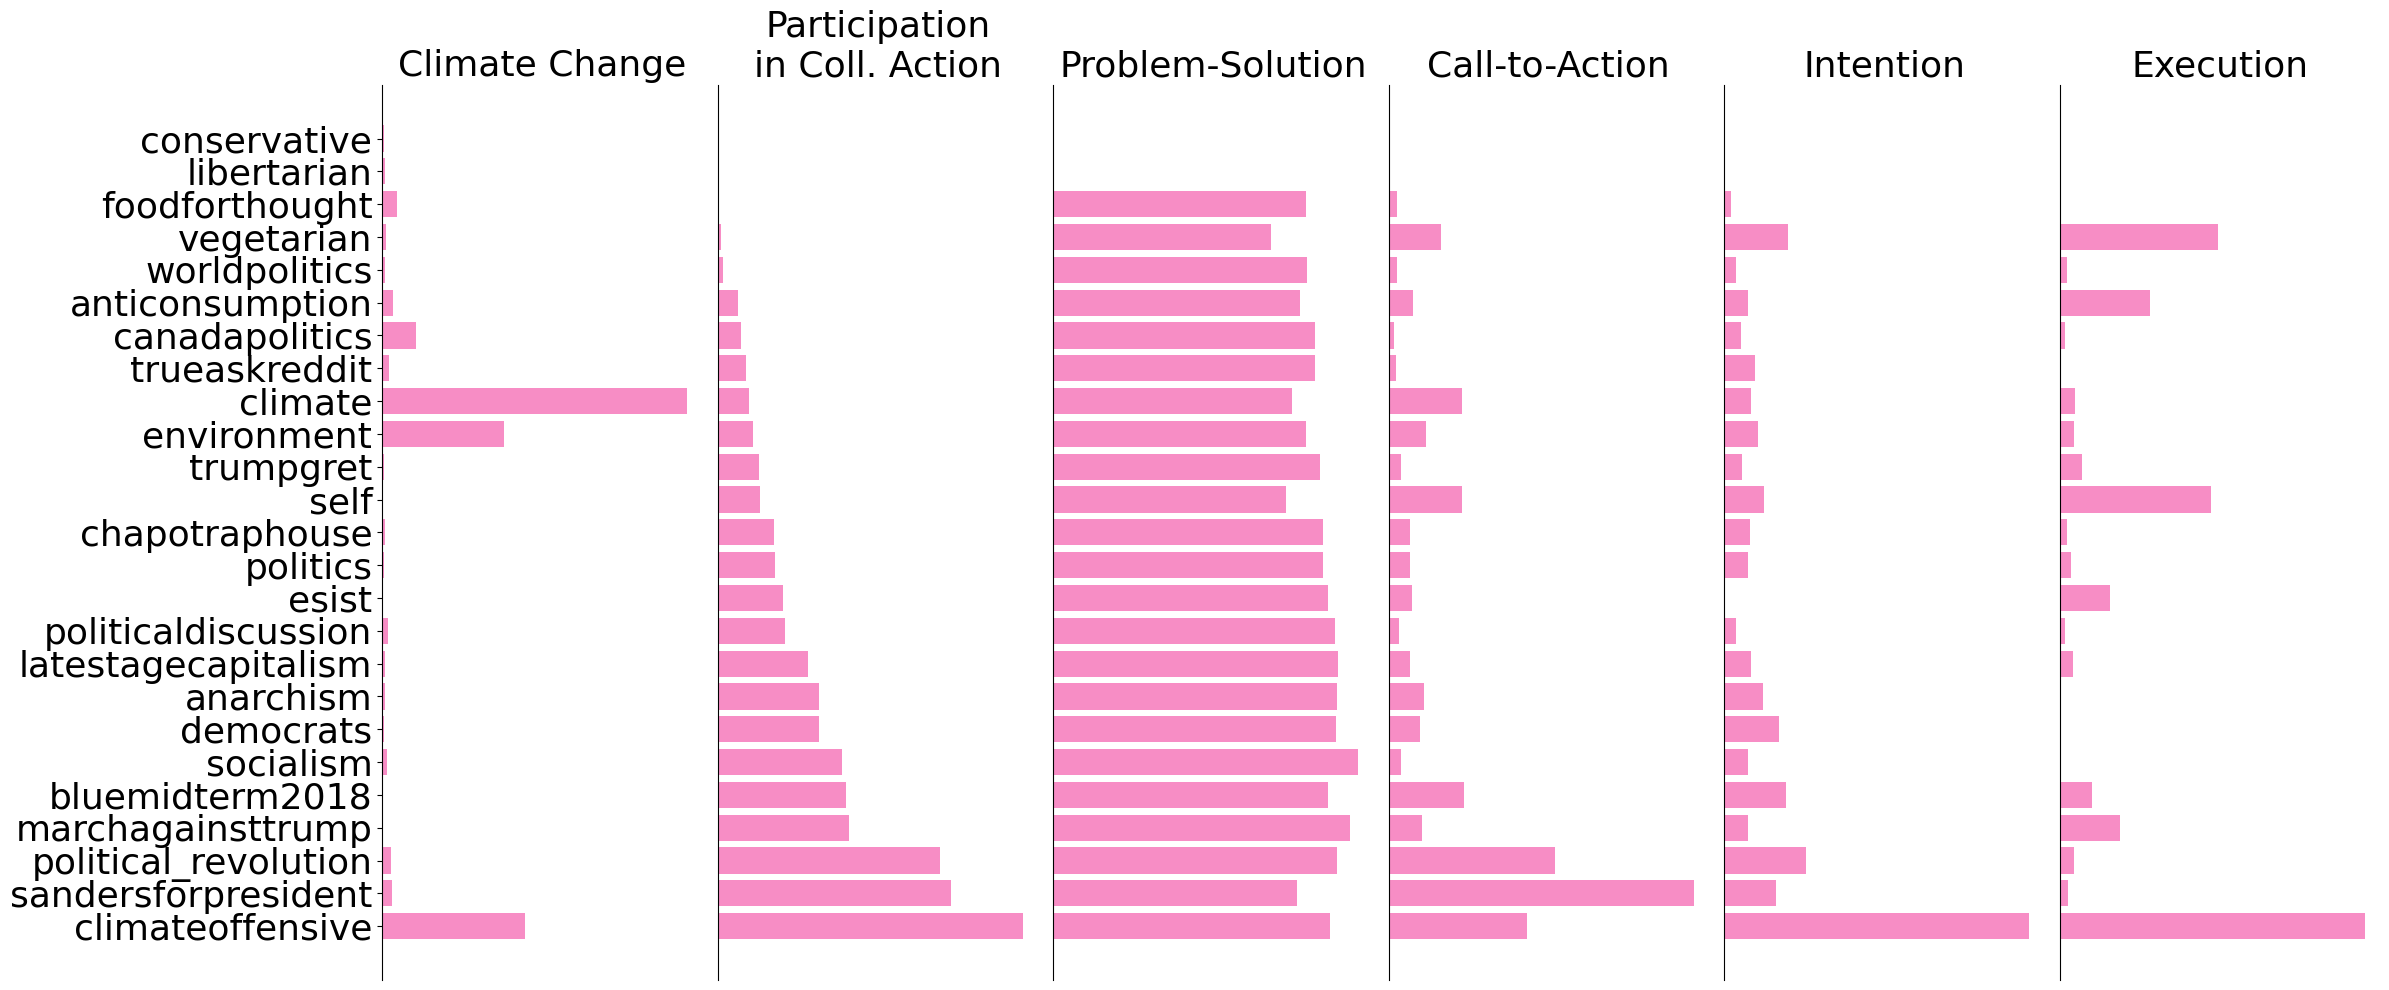

In [897]:
dictionary_titles = {"perc_action_norm": "Participation\nin Coll. Action",
                     "climatechange_perc_norm": "Climate Change",
                        "perc_problemsolution_norm": "Problem-Solution",
                        "perc_calltoaction_norm": "Call-to-Action",
                        "perc_intention_norm": "Intention",
                        "perc_participation_norm": "Execution"}


# min max scaling
predictions_subs_perc['perc_action_norm'] = (predictions_subs_perc['perc_action'] - predictions_subs_perc['perc_action'].min()) / (predictions_subs_perc['perc_action'].max() - predictions_subs_perc['perc_action'].min())
predictions_subs_perc['climatechange_perc_norm'] = (predictions_subs_perc['climatechange_perc'] - predictions_subs_perc['climatechange_perc'].min()) / (predictions_subs_perc['climatechange_perc'].max() - predictions_subs_perc['climatechange_perc'].min())
predictions_subs_perc['perc_problemsolution_norm'] = (predictions_subs_perc['perc_problemsolution'] - predictions_subs_perc['perc_problemsolution'].min()) / (predictions_subs_perc['perc_problemsolution'].max() - predictions_subs_perc['perc_problemsolution'].min())
predictions_subs_perc['perc_calltoaction_norm'] = (predictions_subs_perc['perc_calltoaction'] - predictions_subs_perc['perc_calltoaction'].min()) / (predictions_subs_perc['perc_calltoaction'].max() - predictions_subs_perc['perc_calltoaction'].min())
predictions_subs_perc['perc_intention_norm'] = (predictions_subs_perc['perc_intention'] - predictions_subs_perc['perc_intention'].min()) / (predictions_subs_perc['perc_intention'].max() - predictions_subs_perc['perc_intention'].min())
predictions_subs_perc['perc_participation_norm'] = (predictions_subs_perc['perc_participation'] - predictions_subs_perc['perc_participation'].min()) / (predictions_subs_perc['perc_participation'].max() - predictions_subs_perc['perc_participation'].min())

# Sort by `perc_action` for ordering
predictions_subs_perc = predictions_subs_perc.sort_values(by='perc_action', ascending=False)

# Create 6 subplots in 1 row
fig, axs = plt.subplots(1, 6, figsize=(24, 10))

# Plot normalized bars
for i, metric in enumerate(['climatechange_perc_norm', 'perc_action_norm', 'perc_problemsolution_norm', 'perc_calltoaction_norm', 'perc_intention_norm', 'perc_participation_norm']):
    # Plot bars
    axs[i].barh(predictions_subs_perc['subreddit'], predictions_subs_perc[metric], alpha=0.9, color="#F781BF")
    # title and labels
    axs[i].set_title(dictionary_titles[metric], fontsize=26)

    # keep y axis only for the first plot
    if i != 0:
        axs[i].set_yticks([])
    else:
        # fontsize
        axs[i].tick_params(axis='y', labelsize=26)

    # remove x axis
    axs[i].set_xticks([])


    # remove borders
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)


# Display the plot
plt.tight_layout()

plt.show()
